In [7]:
import matplotlib.pyplot as plt 
from datasets import load_dataset
import pandas as pd
import numpy as np
import json
from pyvi import ViTokenizer
from tqdm import tqdm
import seaborn as sns

/home/link/miniconda3/envs/conlearn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Utils

In [2]:
def load_train_data(train_path:str):
    data = load_dataset('json', data_files=train_path)['train']
    return data['query'], data['document']

def load_benchmark_data(benchmark_path, corpus_path):
    benchmark_data = json.load(open(benchmark_path))
    corpus_data = json.load(open(corpus_path))
    return benchmark_data, corpus_data

In [8]:
def stas_lens(lens:str):
    # Calculate minimum
    minimum = min(lens)

    # Calculate maximum
    maximum = max(lens)

    # Calculate median
    sorted_numbers = sorted(lens)
    n = len(sorted_numbers)
    if n % 2 == 0:
        median = (sorted_numbers[n // 2 - 1] + sorted_numbers[n // 2]) / 2
    else:
        median = sorted_numbers[n // 2]

    # Calculate mean
    mean = sum(lens) / len(lens)

    print("Minimum:", minimum)
    print("Maximum:", maximum)
    print("Median:", median)
    print("Mean:", mean)

def perc_corvered_examples(lens: list, thresh: int = 100):
    sorted_numbers = sorted(lens)
    covered = 0
    for i in sorted_numbers:
        if i <= thresh:
            covered += 1
    print(f"Covered examples percent {round(covered/len(sorted_numbers), 4)}")

def plot_length_distribution(lens: list, axvline: int, name: str):
    # Set the style using Seaborn
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.histplot(lens, bins=100, ax=ax, kde=True, color='skyblue')
    ax.set_title(name, fontsize=16)
    ax.set_xlabel('Length', fontsize=12)
    ax.set_ylabel('Quantity', fontsize=12)
    ax.axvline(axvline, color=(1, 0, 0, 0.3), linestyle='--', linewidth=2)
    sns.despine()

    plt.tight_layout()
    plt.show()


def scatter_plot_distribution(lens: list, threshold: int, name):
    indices = range(len(lens))

    # Create color array based on vertical values
    colors = ['Over' if val > threshold else 'Acceptable' for val in lens]

    # Define color palette for 'Over' and 'Acceptable'
    color_palette = {'Over': '#FF5757', 'Acceptable': '#579CFF'}
    rgba_colors = np.array([color_palette[color] for color in colors])

    sns.set(style='whitegrid')

    # Create scatter plot using Seaborn with smaller dot size
    sns.scatterplot(x=indices, y=lens, hue=colors,
                    palette=color_palette, edgecolor='black', s=10)

    # Overlay scatter plot with colored markers with smaller dot size
    plt.scatter(indices, lens, c=rgba_colors, edgecolors='none')

    # Set labels and title
    plt.xlabel('Index', fontsize=12)
    plt.ylabel('Length', fontsize=12)
    plt.title(name, fontsize=14)

    # Show the plot
    plt.show()

def percen_bar_distribution(lens:list, threshold:int, name):
    sns.set()
    labels = ['Below max length', 'Exceeding max length']
    counts = [
        len([length for length in lens if length <= threshold]) / len(lens) * 100,
        len([length for length in lens if length > threshold]) / len(lens) * 100
    ]

    data = {'Status': labels, 'Percentage number': counts}
    df = pd.DataFrame(data)
    colors = ['blue', 'orange']
    ax = sns.barplot(data=df, x='Status',
                     y='Percentage number', palette=colors)
    plt.xlabel('Status')
    plt.ylabel('Percentage number')
    plt.title(name)

    for i, v in enumerate(counts):
        ax.text(i, v + 1, str(round(v, 2)) + '%', ha='center', va='bottom')
    plt.show()

In [4]:
def eda_train(train_path:str, name:str):
    train_query, train_doc = load_train_data(train_path)
    lens_train_query = [len(item.split())
                        for item in tqdm(train_query)]
    lens_train_document = [len(item.split())
                           for item in tqdm(train_doc)]

    print("-----EDA Query-----")
    stas_lens(lens_train_query)
    perc_corvered_examples(lens_train_query, 64)
    plot_length_distribution(lens_train_query, 64,
                             f'Distribution of len query in {name} train data')
    percen_bar_distribution(lens_train_query, 64,
                            f'The percentage of query exceeds the length threshold in {name}')

    print("-----EDA Document-----")
    stas_lens(lens_train_document)
    perc_corvered_examples(lens_train_document, 256)
    plot_length_distribution(lens_train_document, 256,
                             f'Distribution of len document in {name} train data')
    percen_bar_distribution(lens_train_document, 256,
                            f'The percentage of document exceeds the length threshold in {name}')

In [5]:
def eda_benchmark(benchmark_path:str, corpus_path:str, name:str, vi_tokenize:bool):
    benchmark_data, corpus_data = load_benchmark_data(benchmark_path, corpus_path)
    if vi_tokenize:
        benchmark_lens = [len(ViTokenizer.tokenize(item['query']).split()) for item in tqdm(benchmark_data)]
        corpus_lens = [len(ViTokenizer.tokenize(item['text']).split()) for item in tqdm(corpus_data)]
    else:
        benchmark_lens = [len(item['query'].split()) for item in tqdm(benchmark_data)]
        corpus_lens = [len(item['text'].split()) for item in tqdm(corpus_data)]

    print("-----EDA Query-----")
    stas_lens(benchmark_lens)
    perc_corvered_examples(benchmark_lens, 64)
    plot_length_distribution(benchmark_lens, 64,
                             f'Distribution of len benchmark in {name}')
    percen_bar_distribution(benchmark_lens, 64,
                            f'The percentage of benchmark exceeds the length threshold in {name}')

    print("-----EDA Document-----")
    stas_lens(corpus_lens)
    perc_corvered_examples(corpus_lens, 256)
    plot_length_distribution(corpus_lens, 256,
                             f'Distribution of len corpus in {name}')
    percen_bar_distribution(corpus_lens, 256,
                            f'The percentage of corpus exceeds the length threshold in {name}')

In [14]:
def count_quantity(path):
    data = load_dataset('json', data_files=path)['train']
    print("Quantity: ", data.num_rows)

### 1. Train

##### 1.1 General data

100%|██████████| 2000000/2000000 [02:33<00:00, 13068.14it/s]


-----EDA Query-----
Minimum: 0
Maximum: 11134
Median: 24.0
Mean: 31.1062995
Covered examples percent 0.9336


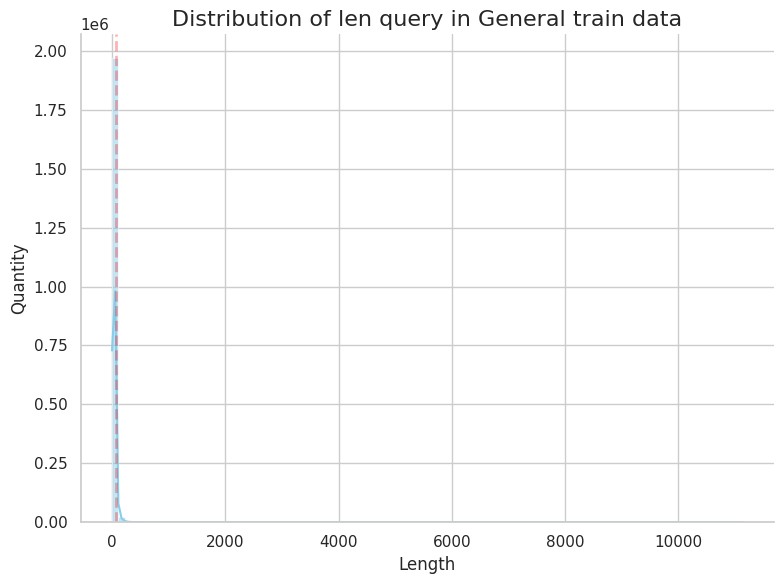

/tmp/ipykernel_2663856/2342166948.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Status',


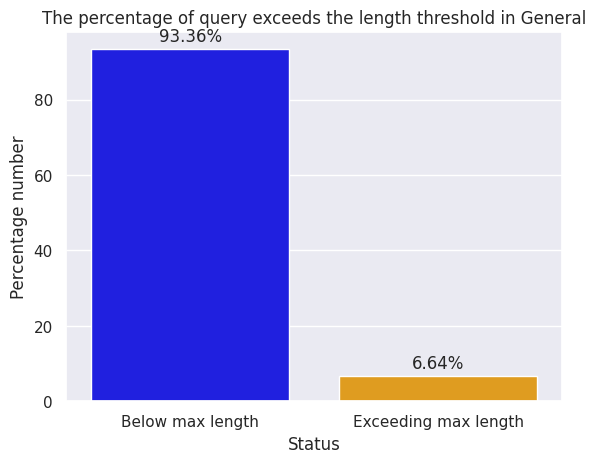

-----EDA Document-----
Minimum: 100
Maximum: 45129
Median: 668.0
Mean: 999.4286685
Covered examples percent 0.0035


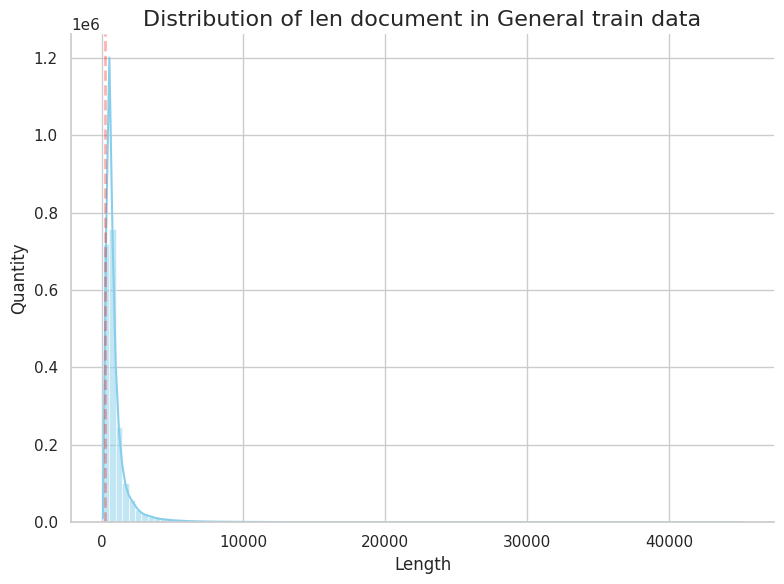

/tmp/ipykernel_2663856/2342166948.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Status',


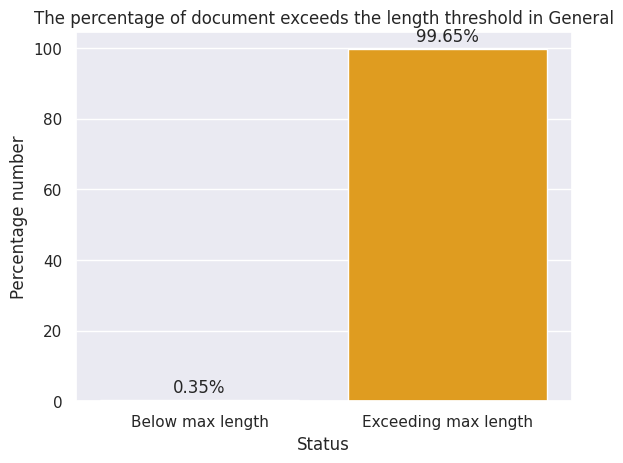

In [28]:
general_train_path = '/home/link/spaces/multi_task/data/word-level/train/data.jsonl'
count_quantity(general_train_path)
eda_train(general_train_path, 'General')

##### 1.2 Legal data

100%|██████████| 412073/412073 [00:29<00:00, 14038.78it/s]


-----EDA Query-----
Minimum: 10
Maximum: 347
Median: 23
Mean: 27.34003683813305
Covered examples percent 0.965


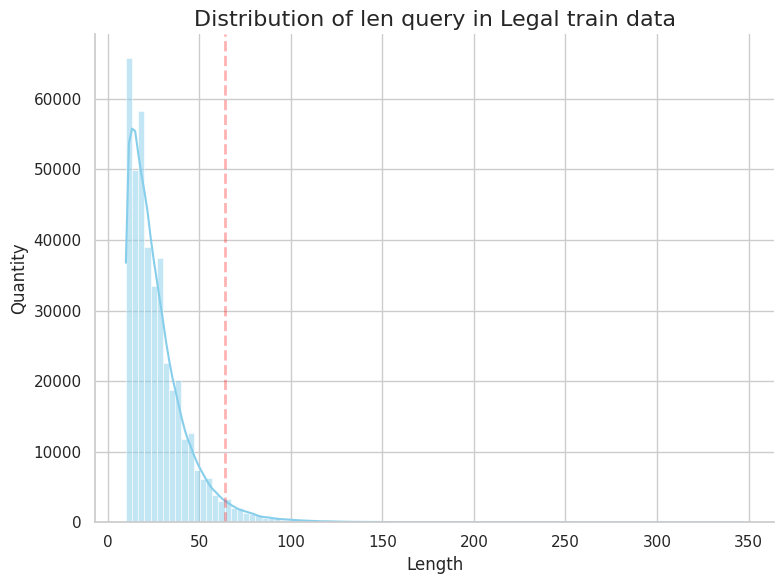

/tmp/ipykernel_2705006/2342166948.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Status',


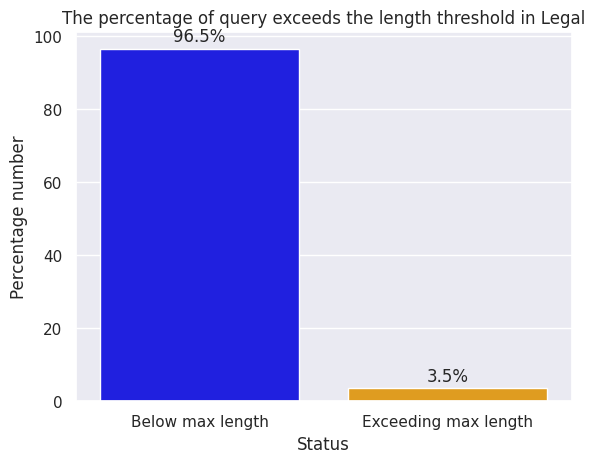

-----EDA Document-----
Minimum: 4
Maximum: 44579
Median: 275
Mean: 885.6075695325828
Covered examples percent 0.471


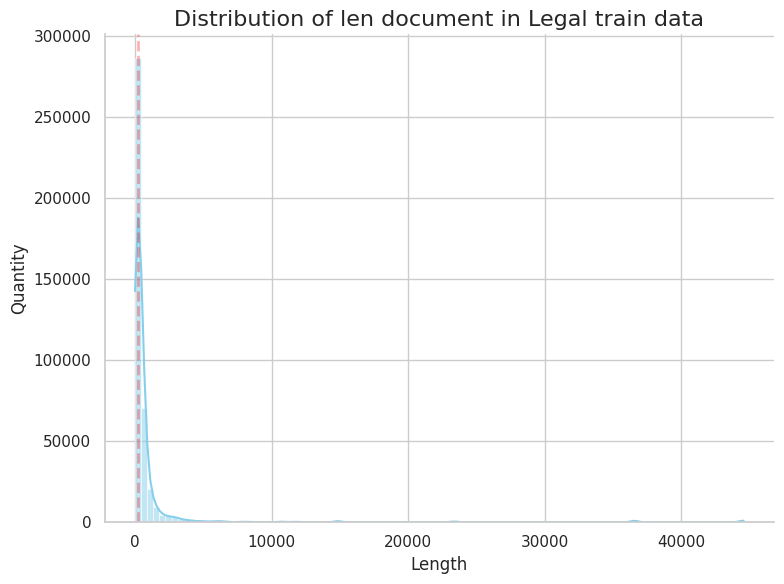

/tmp/ipykernel_2705006/2342166948.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Status',


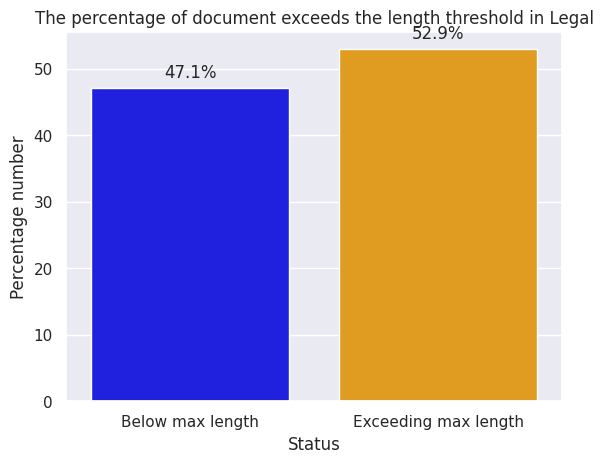

In [10]:
legal_train_path = '/home/link/spaces/chunking/LinhCSE_training/data/train/data.jsonl'
eda_train(legal_train_path, 'Legal')

### 2. Test

##### 2.1 Zalo benchmark

100%|██████████| 3271/3271 [04:27<00:00, 12.23it/s]


-----EDA Query-----
Minimum: 2
Maximum: 34
Median: 14.0
Mean: 14.075719649561952
Covered examples percent 1.0


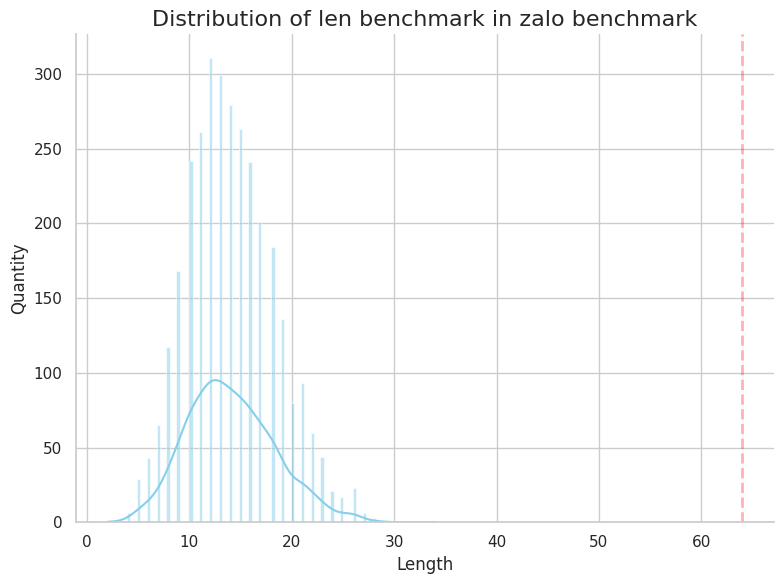

/tmp/ipykernel_2705006/2342166948.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Status',


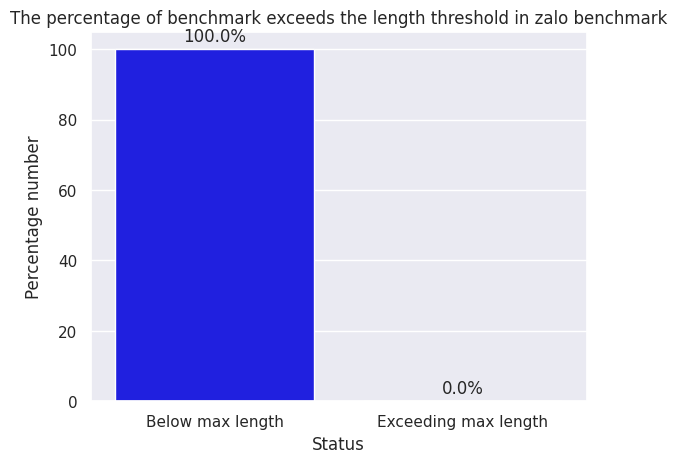

-----EDA Document-----
Minimum: 30
Maximum: 92074
Median: 2806
Mean: 4529.367471721186
Covered examples percent 0.0456


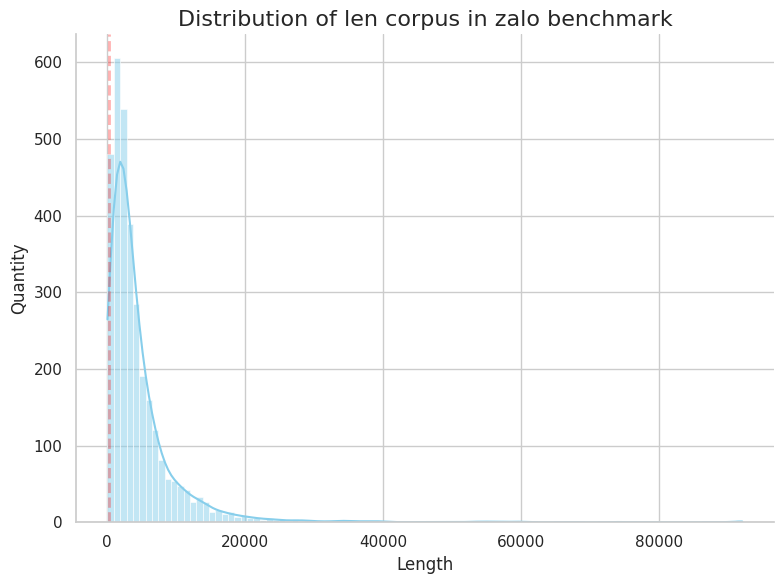

/tmp/ipykernel_2705006/2342166948.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Status',


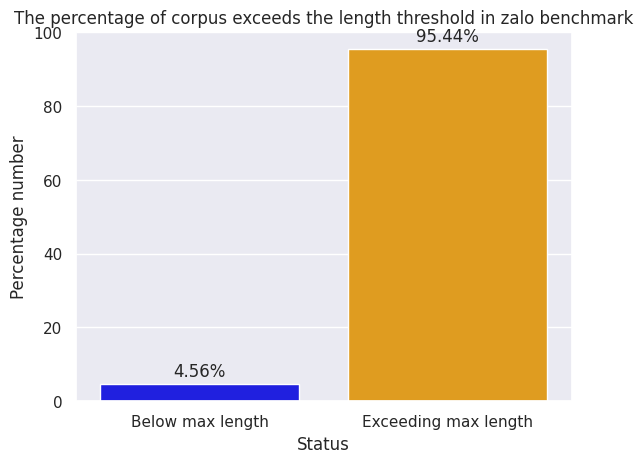

In [7]:
zalo_benchmark_path = '/home/link/spaces/chunking/LinhCSE_training/benchmark/zalo/bm_legal_zalo.json'
zalo_corpus_path = '/home/link/spaces/chunking/LinhCSE_training/benchmark/zalo/corpus_legal.json'
count_quantity(zalo_benchmark_path)
count_quantity(zalo_corpus_path)
eda_benchmark(zalo_benchmark_path, zalo_corpus_path, 'zalo benchmark', vi_tokenize=True)

##### 2.2 General benchmark (long)

100%|██████████| 5000/5000 [00:00<00:00, 17455.73it/s]


-----EDA Query-----
Minimum: 11
Maximum: 71
Median: 28.0
Mean: 27.8742
Covered examples percent 0.9986


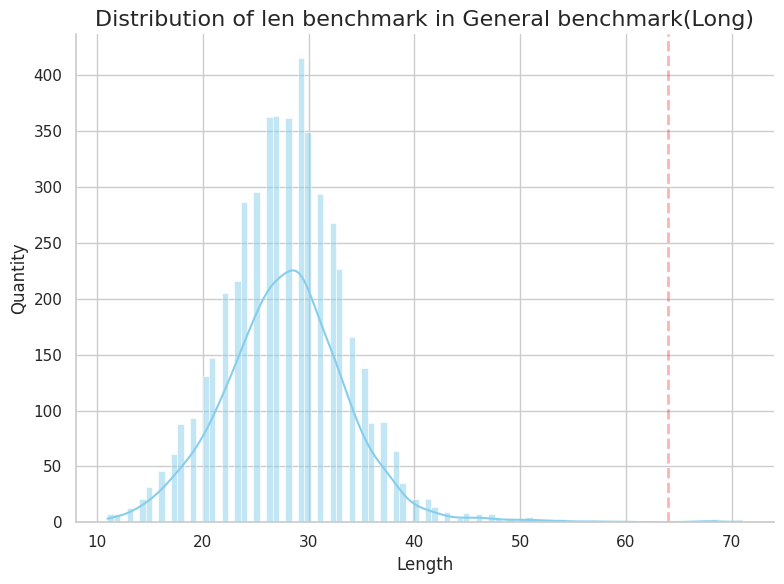

/tmp/ipykernel_2705006/2342166948.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Status',


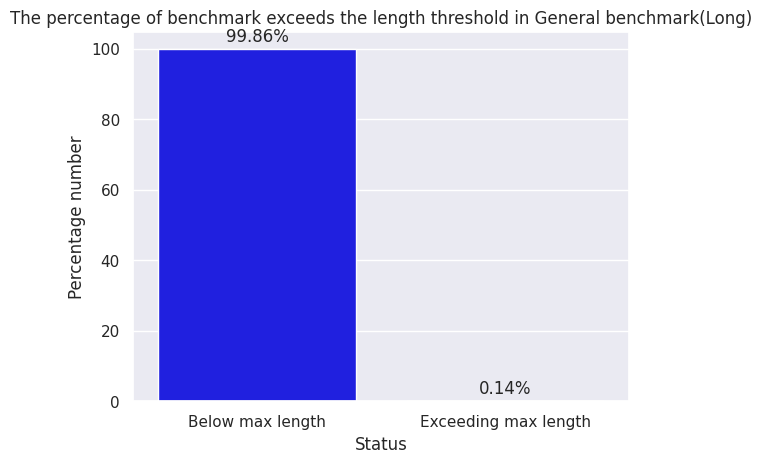

-----EDA Document-----
Minimum: 513
Maximum: 3668
Median: 674.0
Mean: 745.316
Covered examples percent 0.0


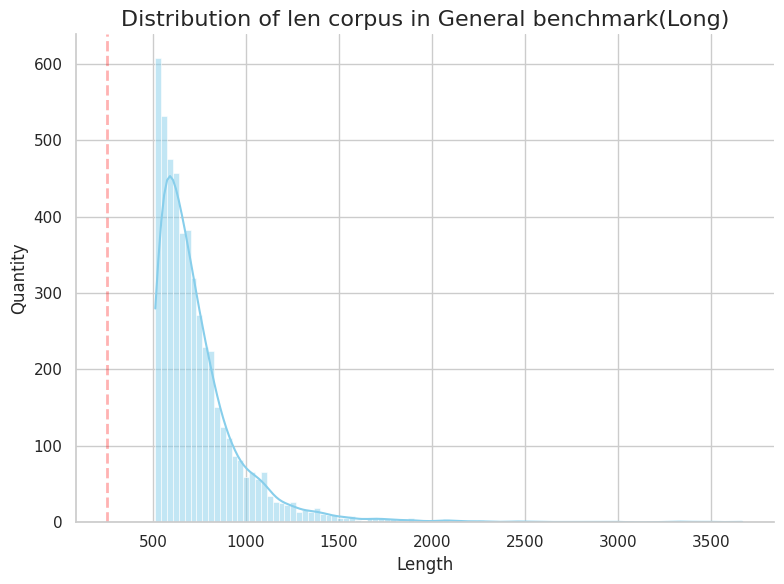

/tmp/ipykernel_2705006/2342166948.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Status',


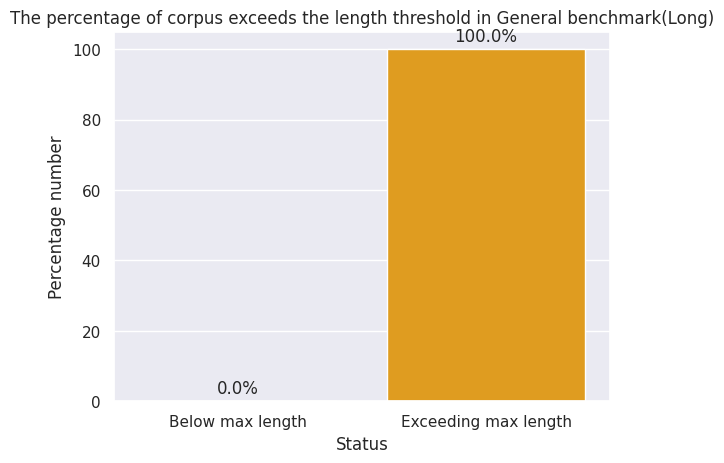

In [8]:
longgeneral_benchmark_path = '/home/link/spaces/chunking/LinhCSE_training/benchmark/general/bm_longgeneral_news.json'
longgeneral_corpus_path = '/home/link/spaces/chunking/LinhCSE_training/benchmark/general/corpus_longgeneral.json'
count_quantity(longgeneral_benchmark_path)
count_quantity(longgeneral_corpus_path)
eda_benchmark(longgeneral_benchmark_path, longgeneral_corpus_path,
              'General benchmark(Long)', vi_tokenize=False)

##### 2.3 General benchmark (short)

100%|██████████| 5000/5000 [00:00<00:00, 72182.92it/s]


-----EDA Query-----
Minimum: 7
Maximum: 81
Median: 25.0
Mean: 24.7914
Covered examples percent 0.9996


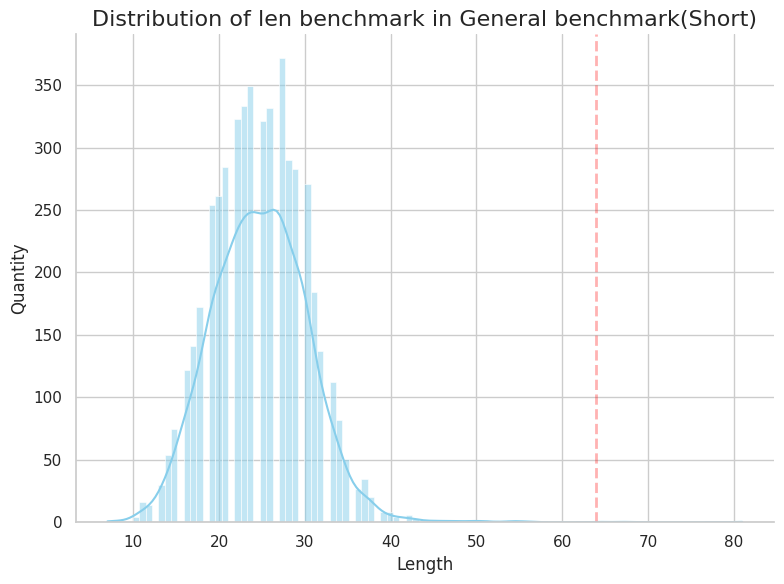

/tmp/ipykernel_2705006/2342166948.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Status',


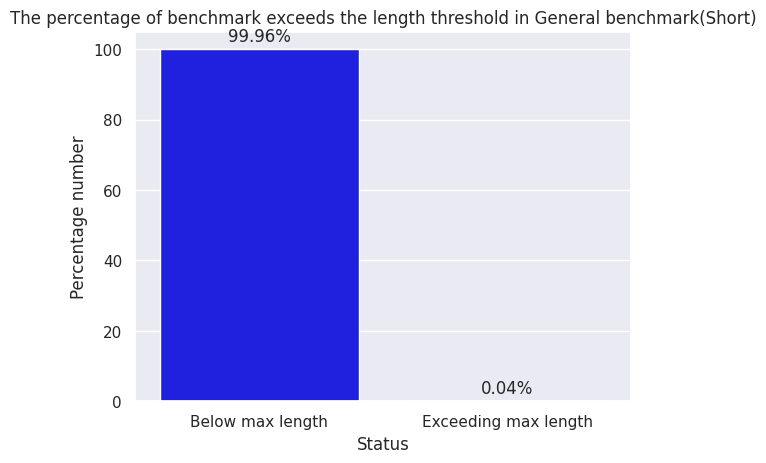

-----EDA Document-----
Minimum: 1
Maximum: 255
Median: 199.0
Mean: 180.2562
Covered examples percent 1.0


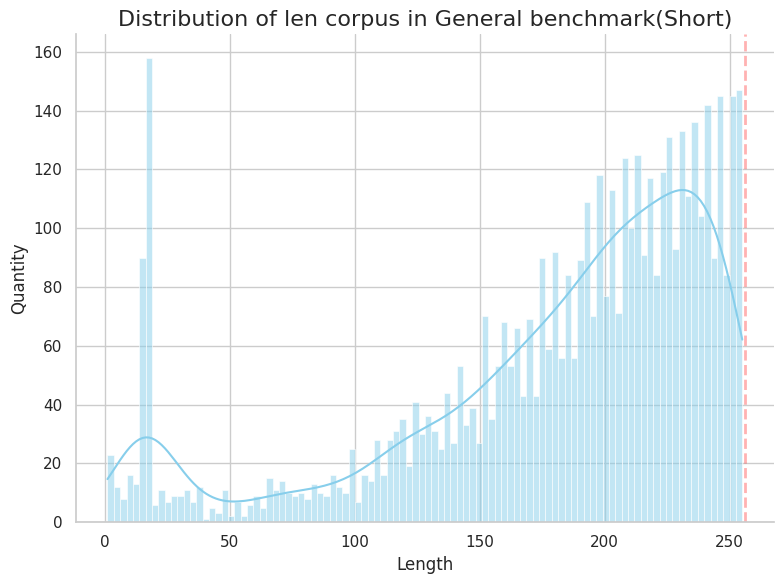

/tmp/ipykernel_2705006/2342166948.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Status',


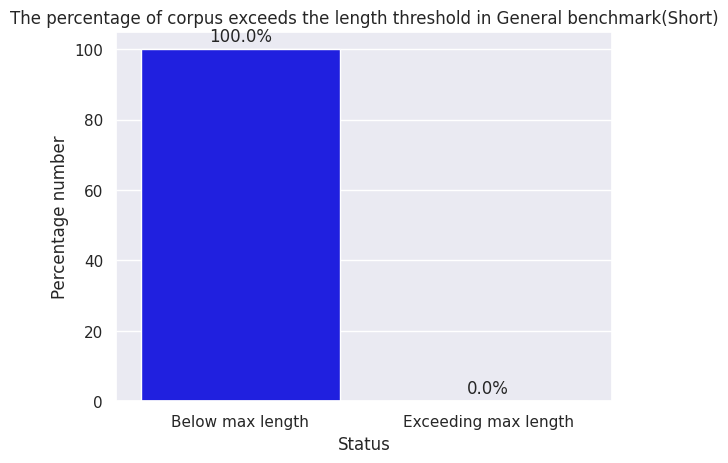

In [9]:
shortgeneral_benchmark_path = '/home/link/spaces/chunking/LinhCSE_training/benchmark/general/bm_shortgeneral_news.json'
shortgeneral_corpus_path = '/home/link/spaces/chunking/LinhCSE_training/benchmark/general/corpus_shortgeneral.json'
eda_benchmark(shortgeneral_benchmark_path, shortgeneral_corpus_path,
              'General benchmark(Short)', vi_tokenize=False)

### 3. Database

In [9]:
import json
database = json.load(
    open('/home/link/spaces/chunking/LinhCSE/data/database/corpus.json'))

num_article_in_item = []
lens_article = []
lens_item = []

for item in tqdm(database):
    num_article_in_item.append(len(item['sections']))
    total_string_in_item = ''
    for section in item['sections']:
        tokennized_text = ViTokenizer.tokenize(section['content'])
        lens_article.append(len(tokennized_text.split()))
        total_string_in_item += section['content'] + " "
    lens_item.append(len(total_string_in_item.split()))

len(num_article_in_item), len(lens_article), len(lens_item)

100%|██████████| 3271/3271 [03:32<00:00, 15.39it/s]


(3271, 61425, 3271)

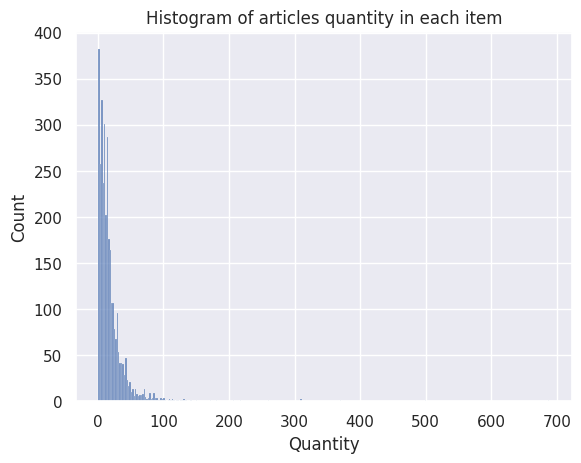

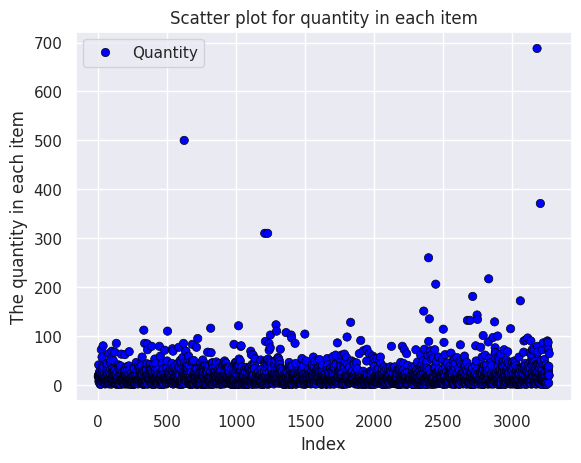

In [15]:
sns.set()
sns.histplot(data=num_article_in_item)
plt.xlabel('Quantity')
plt.ylabel('Count')
plt.title('Histogram of articles quantity in each item')
plt.show()

indices = range(len(num_article_in_item))

# Tạo mảng màu sắc dựa trên giá trị chiều dọc
colors = ['N/A' if val > 16000 else 'Quantity' for val in num_article_in_item]

# Tạo mảng màu sắc RGBA tương ứng với 'Over' và 'Acceptable'
color_palette = {'N/A': 'red', 'Quantity': 'blue'}
rgba_colors = np.array([color_palette[color] for color in colors])

sns.set()
sns.scatterplot(x=indices, y=num_article_in_item, hue=colors,
                palette=color_palette, edgecolor='black')
plt.xlabel('Index')
plt.ylabel('The quantity in each item')
plt.title('Scatter plot for quantity in each item')
plt.show()

-----EDA Document-----
Minimum: 5
Maximum: 54754
Median: 161
Mean: 247.7448433048433
Covered examples percent 0.6979


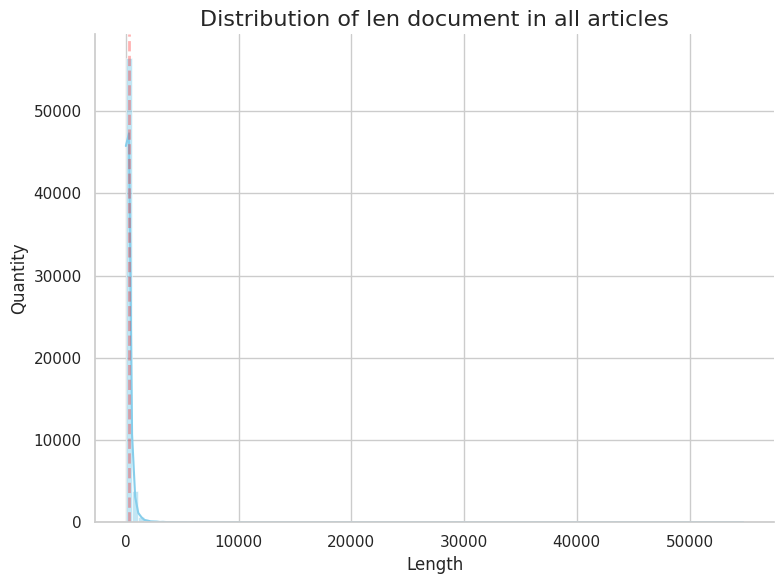

/tmp/ipykernel_2710982/2342166948.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Status',


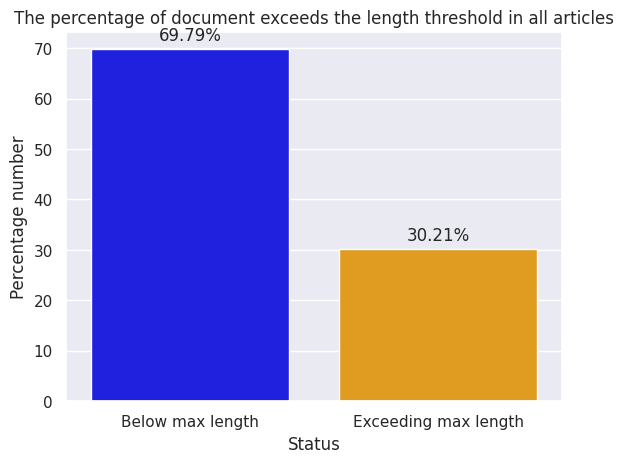

In [10]:
print("-----EDA Document-----")
stas_lens(lens_article)
perc_corvered_examples(lens_article, 256)
plot_length_distribution(lens_article, 256,
                            f'Distribution of len document in all articles')
percen_bar_distribution(lens_article, 256,
                        f'The percentage of document exceeds the length threshold in all articles')

-----EDA Document-----
Minimum: 31
Maximum: 124297
Median: 3507
Mean: 5656.54876184653
Covered examples percent 0.0422


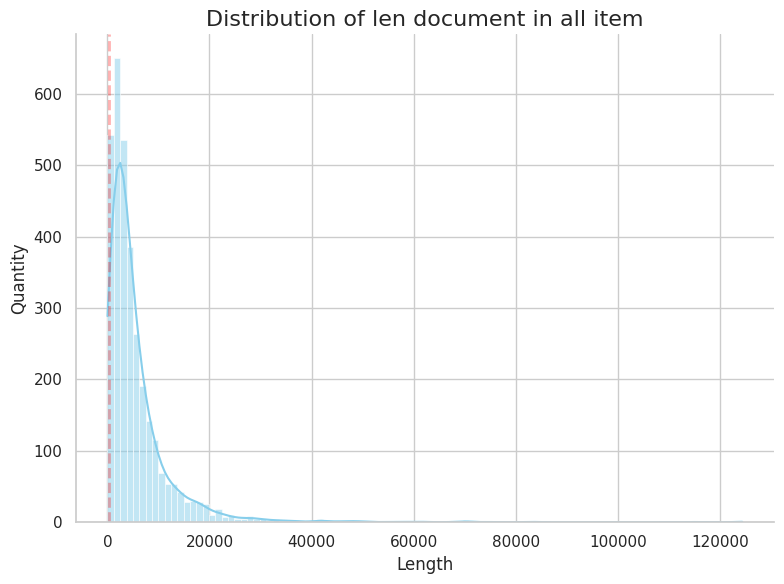

/tmp/ipykernel_2710982/2342166948.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Status',


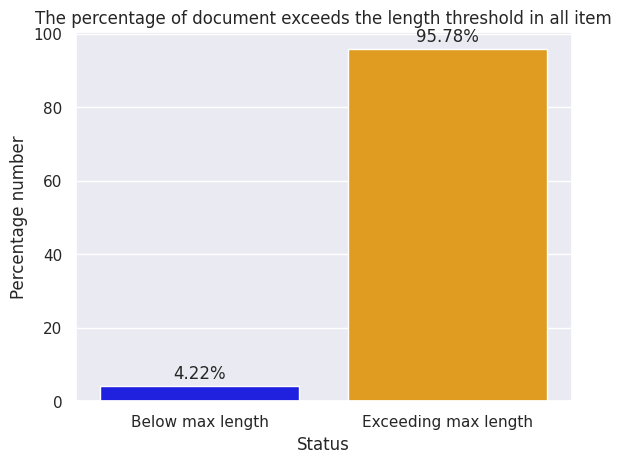

In [12]:
print("-----EDA Document-----")
stas_lens(lens_item)
perc_corvered_examples(lens_item, 256)
plot_length_distribution(lens_item, 256,
                         f'Distribution of len document in all item')
percen_bar_distribution(lens_item, 256,
                        f'The percentage of document exceeds the length threshold in all item')